In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt
import json
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [47]:
df = pd.read_stata('lendingclub_train.dta')
# df.head()
# df.describe()
columns_to_drop = [
    "index",
    "depvar",
    "delinq_2yrs", 
    "total_acc", 
    "out_prncp", 
    "out_prncp_inv", 
    "total_pymnt", 
    "total_pymnt_inv", 
    "total_rec_prncp", 
    "total_rec_int", 
    "total_rec_late_fee", 
    "recoveries", 
    "collection_recovery_fee",
    "last_pymnt_amnt", 
    "last_fico_range_high", 
    "last_fico_range_low", 
    "tot_coll_amt", 
    "tot_cur_bal", 
    "initial_list_status1", 
    "initial_list_status2", 
    "elapsed_t"
]

issue_d_count = 1
while(issue_d_count <= 118):
    word_tmp = "issue_d" + str(issue_d_count)
    columns_to_drop.append(word_tmp)
    issue_d_count += 1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the name of your target column

# Separate majority and minority classes
df_majority = df[df['depvar'] == 0]
df_minority = df[df['depvar'] == 1]

# Count number of instances in the minority class
minority_count = len(df_minority)

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=minority_count, random_state=42)

# Combine minority class with the undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
df_undersampled = df_undersampled.sample(frac=1, random_state=42)

# Now split into features and target, and then into training and testing sets
y = df_undersampled['depvar']
X = df_undersampled.drop(columns=columns_to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X.info(verbose=True,max_cols=None)


In [48]:
# y = df['depvar']
# X = df.drop(columns=columns_to_drop)

# X.info(verbose=True,max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874335 entries, 0 to 874334
Data columns (total 196 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    index                             int32  
 1    loan_amnt                         int32  
 2    funded_amnt                       int32  
 3    funded_amnt_inv                   float64
 4    int_rate                          float64
 5    installment                       float64
 6    annual_inc                        float64
 7    dti                               float64
 8    fico_range_low                    int16  
 9    fico_range_high                   int16  
 10   inq_last_6mths                    int8   
 11   open_acc                          int16  
 12   pub_rec                           int8   
 13   revol_bal                         int32  
 14   revol_util                        float64
 15   collections_12_mths_ex_med        int8   
 16   acc_now_delinq    

# Hyperparameter Tuning

In [55]:
# Create a random subset for hyperparameter tuning (e.g., 1% of the data)
X_subset, _, y_subset, _ = train_test_split(X, y, test_size=0.99, random_state=42)

# Calculate class weights for the subset
class_weights = compute_class_weight('balanced', classes=np.unique(y_subset), y=y_subset)
class_weight_dict = dict(enumerate(class_weights))

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_subset.shape[1],)))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the Hyperband tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=2,
                     directory='my_dir',
                     project_name='hyperband_tuning')

# Start hyperparameter search
tuner.search(X_subset, y_subset, 
             epochs=10, 
             validation_split=0.2,  # Assuming you want to use a validation split here
             class_weight=class_weight_dict)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Reloading Tuner from my_dir/hyperband_tuning/tuner0.json


In [54]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Prepare the best hyperparameters for saving
best_hyperparameters = {
    'units': best_hps.get('units'),
    'dropout': best_hps.get('dropout'),
    'learning_rate': best_hps.get('learning_rate')
    # Add other hyperparameters here if you have more
}

# Save the best hyperparameters to a JSON file
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

print("Best hyperparameters saved to 'best_hyperparameters.json'")


Best hyperparameters saved to 'best_hyperparameters.json'


# Actual Training

In [58]:
_, X_temp, _, y_temp = train_test_split(X, y, test_size=0.99, random_state=42)
X_train, X_test, y_train, y_test =  train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Class Weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


# Load best hyperparameters
with open('best_hyperparameters.json') as f:
    best_hps = json.load(f)

# Create the model with the best hyperparameters
model = Sequential()
model.add(Dense(units=best_hps['units'], activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(best_hps['dropout']))
model.add(Dense(1, activation='sigmoid'))


# Assuming X and y are your full dataset excluding the subset used for tuning
# Train the model
model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=100, batch_size=256, class_weight=class_weight_dict)  # Adjust epochs and batch_size as needed

# Save the final trained model
model.save('final_trained_model.h5')


Epoch 1/100
3416/3416 [==============================] - 6s 2ms/step - loss: 437.2713 - accuracy: 0.4771
Epoch 2/100
3416/3416 [==============================] - 6s 2ms/step - loss: 1.2065 - accuracy: 0.5888
Epoch 3/100
3416/3416 [==============================] - 7s 2ms/step - loss: 0.7256 - accuracy: 0.5765
Epoch 4/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.7298 - accuracy: 0.4408
Epoch 5/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.7117 - accuracy: 0.4706
Epoch 6/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.7518 - accuracy: 0.4817
Epoch 7/100
3416/3416 [==============================] - 5s 2ms/step - loss: 0.6949 - accuracy: 0.4164
Epoch 8/100
3416/3416 [==============================] - 5s 2ms/step - loss: 0.6947 - accuracy: 0.4426
Epoch 9/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.7014 - accuracy: 0.4970
Epoch 10/100
3416/3416 [==============================] - 5s 2ms/step -

/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot the learning 

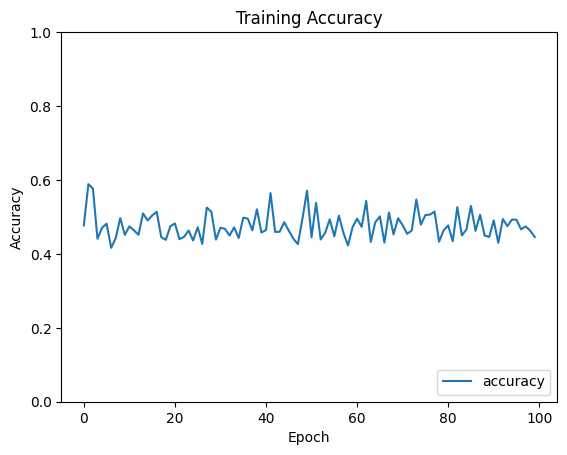

5410/5410 - 2s - loss: 0.6876 - accuracy: 0.8373 - 2s/epoch - 351us/step
Test accuracy: 0.8372506499290466
5410/5410 [==============================] - 2s 320us/step
Confusion Matrix:
 [[144944      0]
 [ 28175      0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    144944
         1.0       0.00      0.00      0.00     28175

    accuracy                           0.84    173119
   macro avg       0.42      0.50      0.46    173119
weighted avg       0.70      0.84      0.76    173119



/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [59]:

# Plotting the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}")

# Predictions for confusion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)  # Adjust this line if not a binary classification

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-Score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)